## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
#importing header files 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
#importing dataset
df= pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [6]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()    

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#comparing by rows to see where treatment and new page dont align
dont_line_up = df[(df['group']=='treatment')!= (df['landing_page']=='new_page')]
dont_line_up.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#new dataframe with unaligned entries removed
df2= df[df[['group','landing_page']].apply(lambda x:x[0]=='control' and x[1]=='old_page' or x[0]=='treatment' and x[1]=='new_page', axis=1)]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
#the repeated row is row number 2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#remove duplicates under subset user id, but keeping the first row of duplicates 
df2=df2.drop_duplicates(subset='user_id', keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
#finding total rows 
df2.shape[0]

290584

In [18]:
#dividing no. of occurences of new page by total rows to find the probability 
prob_new_page=df2.query('landing_page=="new_page"').count()/290584
prob_new_page[1]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There isnt sufficient evidence to say that as the conversion rates before and after are 0.11965919355605512 and 0.11959708724499628 respectively. The difference is not enough to derive a conclusion. 

Similarly, the control group old page conversion (0.1203863045004612) compared to the treatment group new page (0.11880806551510564) are also very close and we cannot conclusively infer the above. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#solved for in part I
p_new= df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#question assumes p old = p new under null
p_old= p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
#rows where landing page=new page 
n_new= df2.query('landing_page=="new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
#rows where anding page = old page 
n_old= df2.query('landing_page=="old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#simulating a new array using the np.random.binomial function. No specific reason for using it, seemed like the best fit and consistent with later exercise 
new_page_converted= np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted= np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean()-old_page_converted.mean()

-7.114868423542531e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
#simulating another 10000 value array using random.binomial and dividing by n_new and n_old respectively
p_diffs= []
new= np.random.binomial(n_new, p_new, 10000)/n_new
old= np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new-old

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

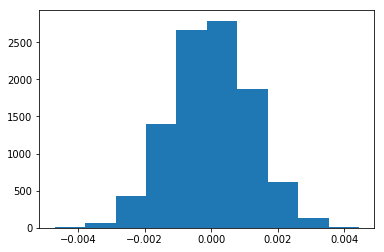

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

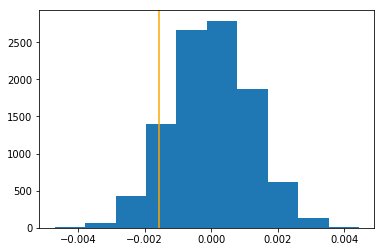

In [28]:
#solved for in part I
difference= df2.query('group=="treatment"')['converted'].mean()- df2.query('group=="control"')['converted'].mean()

#plotting
plt.hist(p_diffs, alpha=1)
plt.axvline(difference, color='orange');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In [29]:
p_val= (p_diffs > difference).mean()
p_val

0.9048

In part J, we have calculated the proportion of our simulated array that is greater than the observed difference from our dataset. 

In scientific studies this is the p-value and is defined as the probability of finding the observed, or more extreme, results when the null hypothesis (H0) of a study question is true.

We computed a p value of approx. 0.904, which is significantly greater than the null hypothesis (0.5000619442226688). Hence we can say there is no significant difference between the old/new pages, and must accept the null hypthesis. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group=="treatment" and converted==1').converted.shape[0]
convert_new = df2.query('group=="control" and converted==1').converted.shape[0]
n_old = df2.query('group=="treatment"').converted.shape[0]
n_new = df2.query('group=="control"').converted.shape[0]

print(convert_old, convert_new, n_old, n_new)

17264 17489 145310 145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

A z score is the number of standard deviations the element is from the mean. 1.31 translates to between the 1st and 2nd standard deviation (60-90% of all elements). 

When the p value is the null hypothesis (~0.05), we accept it as the the z score is greater. ie. the old page is at least similar to if not better than the new page. 

The p value from the z_test is almost identical to the simulation, we can say it agrees with the finding. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

I think we should use the Logistic Regression method as we have the ocnversion rate which relies on categories and has 2 outcomes. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#creating df2 regression (df2r) dataframe to not manipulate df2 further
df2r= df2.copy()
df2r.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
#adding column intercept for log regression
df2r['intercept']=1

In [34]:
#adding the necessary data to the new dataframe and removing any additional columns we wont need in this excercise
df2r[['group1', 'ab_page' ]] = pd.get_dummies(df2r.group)
df2r[['treatment1', 'landing2' ]] = pd.get_dummies(df2.landing_page)
df2r = df2r.drop(['timestamp','group1','landing2'], axis=1)
df2r.head()

,user_id,group,landing_page,converted,intercept,ab_page,treatment1
0,851104,control,old_page,0,1,0,0
1,804228,control,old_page,0,1,0,0
2,661590,treatment,new_page,0,1,1,1
3,853541,treatment,new_page,0,1,1,1
4,864975,control,old_page,1,1,0,0


In [35]:
#renaming the new treatment column 
df2r= df2r.rename(columns={'treatment1':'treatment_new'})
df2r.head()

,user_id,group,landing_page,converted,intercept,ab_page,treatment_new
0,851104,control,old_page,0,1,0,0
1,804228,control,old_page,0,1,0,0
2,661590,treatment,new_page,0,1,1,1
3,853541,treatment,new_page,0,1,1,1
4,864975,control,old_page,1,1,0,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
import statsmodels.api as sm
log = sm.Logit(df2r['converted'], df2r[['intercept', 'ab_page']])
result = log.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:17:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

P value (AB page) is 0.190 while that from the prev. section is 0.903. There is a difference because in part two we only tested one side of the hypothesis, ie. new page conversion rate > old page. It did not factor in the converse, ie. new page conversion rate < old page conversion rate. When this is factored in, as in the case on the ab page, our p value differs. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

We may have to factor other influences like geography, age, timing etc. It could also be worthwhile looking at any paradoxical and or correlated information as well, it could just be trend that loses its credibiity as more data is added or manipulated. 

As we add more non numerical data, it may become slightly difficult to interpret it. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2r.set_index('user_id'), how='inner')
df_new.head()

,country,group,landing_page,converted,intercept,ab_page,treatment_new
user_id,,,,,,,
834778,UK,control,old_page,0,1,0,0
928468,US,treatment,new_page,0,1,1,1
822059,UK,treatment,new_page,1,1,1,1
711597,UK,control,old_page,0,1,0,0
710616,UK,treatment,new_page,0,1,1,1


In [44]:
### Create the necessary dummy variables
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
df_new[['CA', 'US', 'UK']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,group,landing_page,converted,intercept,ab_page,treatment_new,CA,US,UK
user_id,,,,,,,,,,
834778,UK,control,old_page,0,1,0,0,0,1,0
928468,US,treatment,new_page,0,1,1,1,0,0,1
822059,UK,treatment,new_page,1,1,1,1,0,1,0
711597,UK,control,old_page,0,1,0,0,0,1,0
710616,UK,treatment,new_page,0,1,1,1,0,1,0


In [46]:
#as CA appears to have no impact on conversion, as per question we remove it
df_new = df_new.drop(['country', 'CA'], axis=1)
df_new.head()

,group,landing_page,converted,intercept,ab_page,treatment_new,US,UK
user_id,,,,,,,,
834778,control,old_page,0,1,0,0,1,0
928468,treatment,new_page,0,1,1,1,0,1
822059,treatment,new_page,1,1,1,1,1,0
711597,control,old_page,0,1,0,0,1,0
710616,treatment,new_page,0,1,1,1,1,0


In [47]:
#performing log regression by 'converted'
log_by_country = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results_by_country = log_by_country.fit()
results_by_country.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:19:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0408      0.027      1.516      0.130      -0.012       0.093
US             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

The p values for the individual countries are greater than the null hypothesis (H0=0.05), hence we dont consider these and accept the null hypothesis, ie. the new page is not better. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
### Fit Your Linear Model And Obtain the Results
##performing log regression by 'AB page'
log_by_ab = sm.Logit(df_new['ab_page'], df_new[['intercept', 'US', 'UK']])
results_by_ab = log_by_ab.fit()
results_by_ab.summary()

Optimization terminated successfully.
         Current function value: 0.760413
         Iterations 3


C:\Users\vpal005\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\vpal005\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\vpal005\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ab_page   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:                     inf
Time:                        13:27:25   Log-Likelihood:            -2.2096e+05
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0142      0.017      0.855      0.392      -0.018       0.047
US            -0.0212      0.018     -1.166      0.244      -0.057       0.014
UK            -0.0124      0.017     -0.720      0.472      -0.046       0.021
==============================================================================
"""

In [ ]:
The p values are not significant, we accept the null hypothesis. 

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.